In [1]:
import geopandas as gpd
from shapely import geometry
import matplotlib.pyplot as plt
from pathlib import Path
import requests
import rasterio
from rasterio.warp import transform_bounds
from rasterio.io import MemoryFile
from affine import Affine
import concurrent.futures
from rasterio.transform import array_bounds
import numpy as np
from rasterio.merge import merge
from rasterio import default_gtiff_profile
from tqdm import tqdm

from orinoco import reproject_arr_to_match_profile

In [22]:
DATA_DIR_NAME = f'data/asf_data_coregistered'
DATA_DIR = Path(DATA_DIR_NAME)
DATA_DIR.exists()

True

In [23]:
DATA_DIR.parent

PosixPath('data')

In [24]:
HANSEN_DATA_DEST_DIR = DATA_DIR.parent/'hansen_data'
HANSEN_DATA_DEST_DIR.mkdir(exist_ok=True, parents=True)


In [25]:
dem_path = DATA_DIR/'dem.tif'
with rasterio.open(dem_path) as ds:
    dem = ds.read(1)
    dem_profile = ds.profile
    dem_bounds = ds.bounds

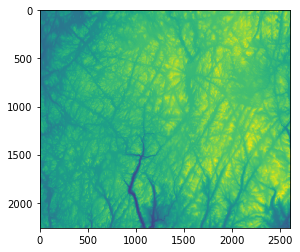

In [26]:
plt.imshow(dem)

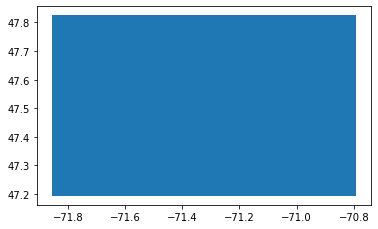

In [27]:
dem_bounds = transform_bounds(dem_profile['crs'], {'init': 'epsg:4326'}, *dem_bounds)
dem_box = geometry.box(*dem_bounds)
df_box = gpd.GeoDataFrame(geometry=[dem_box], crs={'init': 'epsg:4326'})
df_box.plot()

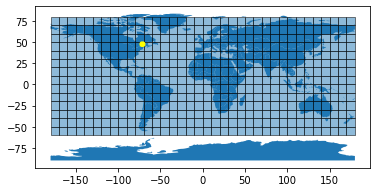

In [8]:
fig, ax = plt.subplots()

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax)

df_treecover = gpd.read_file('hansen_db/hansen_db.geojson')
df_treecover.plot(ax=ax, alpha=.5, edgecolor='black')
df_box.buffer(3).plot(ax=ax, facecolor='yellow')

In [9]:
tiles_to_get = gpd.sjoin(df_treecover, df_box, how='inner', op='intersects').reset_index(drop=True)
tiles_to_get

,treecover_2000_url,mosaic_2000_url,mosaic_2019_url,geometry,index_right
0,https://storage.googleapis.com/earthenginepart...,https://storage.googleapis.com/earthenginepart...,https://storage.googleapis.com/earthenginepart...,"POLYGON ((-70 40, -70 50, -80 50, -80 40, -70 ...",0


In [10]:
def get_hansen_tile(url, dest_dir=HANSEN_DATA_DEST_DIR):
    dest_path = dest_dir/(url.split('/')[-1])
    
    r = requests.get(url)
    with open(dest_path, "wb") as file:
        file.write(r.content)
    return dest_path

In [11]:
tiles_to_get.treecover_2000_url.tolist()

['https://storage.googleapis.com/earthenginepartners-hansen/GFC2015/Hansen_GFC2015_treecover2000_50N_080W.tif']

In [12]:
treecover_dest_paths = list(map(get_hansen_tile, tiles_to_get.treecover_2000_url.tolist()))
treecover_dest_paths

[PosixPath('data/hansen_data/Hansen_GFC2015_treecover2000_50N_080W.tif')]

In [13]:
mosaic_2000_dest_paths = list(map(get_hansen_tile, tiles_to_get.mosaic_2000_url.tolist()))
mosaic_2000_dest_paths

[PosixPath('data/hansen_data/Hansen_GFC2015_first_50N_080W.tif')]

In [15]:
# mosaic_2019_dest_paths = list(map(get_hansen_tile, tiles_to_get.mosaic_2019_url.tolist()))
# mosaic_2019_dest_paths

# Merge and write

## Treecover

In [28]:
datasets = list(map(rasterio.open, treecover_dest_paths))
merged_treecover_arr, merged_transform = merge(datasets)
list(map(lambda x: x.close(), datasets))

[None]

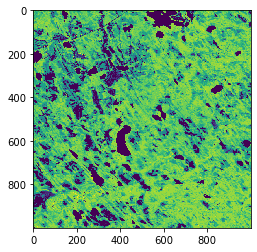

In [29]:
plt.imshow(merged_treecover_arr[0, :1000, :1000])

In [30]:
with rasterio.open(treecover_dest_paths[0]):
    profile = ds.profile
merged_profile = profile.copy()

In [31]:
merged_profile['nodata'] = None
merged_profile['count'] = 1
merged_profile['width'] = merged_treecover_arr.shape[1]
merged_profile['height'] = merged_treecover_arr.shape[0]
merged_profile['transform'] = merged_transform
merged_profile['crs'] = {'init': 'epsg:4326'}

In [32]:
merged_profile['dtype'] = str(merged_treecover_arr.dtype)
cropped_treecover_2000_arr, cropped_hansen_profile = reproject_arr_to_match_profile(merged_treecover_arr, merged_profile, dem_profile)

In [33]:
with rasterio.open(DATA_DIR/'hansen_treecover_2000.tif', 'w', **cropped_hansen_profile) as ds:
    ds.write(cropped_treecover_2000_arr)

## Mosaics

In [ ]:
# datasets = list(map(rasterio.open, mosaic_2000_dest_paths))
# merged_mosaic_2000_arr, merged_transform = merge(datasets)
# list(map(lambda x: x.close(), datasets))

In [ ]:
# merged_mosaic_2000_arr.shape

In [ ]:
# merged_profile['dtype'] = str(merged_mosaic_2000_arr.dtype)
# merged_profile['count'] = merged_mosaic_2000_arr.shape[0]
# cropped_mosaic_2000_arr, cropped_hansen_profile = reproject_arr_to_match_profile(merged_mosaic_2000_arr, merged_profile, dem_profile)

In [ ]:
# with rasterio.open(DATA_DIR/'hansen_mosaic_2000.tif', 'w', **cropped_hansen_profile) as ds:
#     ds.write(cropped_mosaic_2000_arr)

In [ ]:
# datasets = list(map(rasterio.open, mosaic_2019_dest_paths))
# merged_mosaic_2019_arr, merged_transform = merge(datasets)
# list(map(lambda x: x.close(), datasets))

In [ ]:
# cropped_mosaic_2019_arr, cropped_hansen_profile = reproject_arr_to_match_profile(merged_mosaic_2019_arr, merged_profile, dem_profile)

In [ ]:
# with rasterio.open(DATA_DIR/'hansen_mosaic_2019.tif', 'w', **cropped_hansen_profile) as ds:
#     ds.write(cropped_mosaic_2019_arr)

In [ ]:
# plt.imshow(cropped_mosaic_2019_arr[1, ...])